# references
1. https://www.kaggle.com/columbia2131/device-eda-interpolate-by-removing-device-en-ja

# Load Libraries

In [67]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [53]:
notebookName = 'Baseline'
PATH = Path(f"./models/{notebookName}")

In [54]:
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0

0
1
2
3


In [55]:
num_files

4

In [56]:
RANDOM_STATE = 1990
lr = 0.0005
batch_size = 128
EPOCH_NUM = 1000

torch.manual_seed(RANDOM_STATE)

experience_name = f"{num_files}"
checkpoint_name = "check_point"
model_name = str("model - " + experience_name)
param_name = str("param - " + experience_name)
result_name = str("result - " + experience_name)

dummy_path = str(PATH / f"{num_files}")
checkpoint_path = str(PATH / f"{checkpoint_name}.pth")
model_path = str(PATH / f"{model_name}.pth")
param_path = str(PATH / f"{param_name}.pth")
result_path = str(PATH / f"{result_name}.csv")
model_path, param_path, result_path

('models\\Baseline\\model - 4.pth',
 'models\\Baseline\\param - 4.pth',
 'models\\Baseline\\result - 4.csv')

# Useful Functions

In [57]:
def calc_haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    c = 2 * np.arcsin(a ** 0.5)
    dist = 6_367_000 * c
    return dist

In [58]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df, meter_score , score

In [59]:
def check_score_np(predict:torch.Tensor, target:torch.Tensor):
    m = []
    predict = predict.detach().numpy()
    target = target.detach().numpy()
    for i in range(predict.shape[0]):
        temp = calc_haversine(predict[i,0], predict[i,1], target[i,0], target[i,1])
        m.append(temp)
    
    m = np.array(m)
    score = (np.percentile(m, 50) + np.percentile(m, 95))/2
    
    return score

# Load Datasets

In [60]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
df_train = pd.read_pickle(str(data_dir / "gsdc_train.pkl.gzip"))

In [61]:
# check score
df_train, default_loss, default_meas = check_score(df_train)

error meter: 3.84684837499064
score: 5.2879706490841585


# Feature Engineering
## Simple view, what is in data frame.

In [62]:
print(df_train.shape)
df_train.head()

(131342, 111)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,utcTimeMillis_x,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,...,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM,meter
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965654e+13,-0.000502,...,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647,3.586842
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965754e+13,-0.003537,...,411.162,-3013.649,65954.431,-0.002,2.592442e+07,3.897,-222.675,7.111,5.174,2.745901
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965854e+13,0.002028,...,-2776.605,-434.445,1223.261,0.000,2.131445e+07,1.499,0.000,4.777,3.371,1.888409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965954e+13,-0.015753,...,411.755,-3013.528,65954.426,-0.002,2.592544e+07,3.598,-220.611,7.113,5.183,1.213483
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,1.589494e+12,1.734189e+13,0.875268,...,-81.334,-3057.885,-3909.257,0.001,2.318871e+07,10.493,0.000,7.313,5.311,0.664080


In [63]:
for c in df_train.columns:
    print(c)
    print(df_train[c].describe())
    print()

collectionName
count                  131342
unique                     29
top       2021-01-04-US-RWC-1
freq                     8293
Name: collectionName, dtype: object

phoneName
count     131342
unique         7
top       Pixel4
freq       48153
Name: phoneName, dtype: object

millisSinceGpsEpoch
count    1.313420e+05
mean     1.287913e+12
std      1.162110e+10
min      1.273529e+12
25%      1.275424e+12
50%      1.283279e+12
75%      1.302558e+12
max      1.303771e+12
Name: millisSinceGpsEpoch, dtype: float64

latDeg
count    131342.000000
mean         37.435206
std           0.082712
min          37.321683
25%          37.371575
50%          37.424360
75%          37.469109
max          37.690836
Name: latDeg, dtype: float64

lngDeg
count    131342.000000
mean       -122.154925
std           0.145974
min        -122.472214
25%        -122.275109
50%        -122.118311
75%        -122.069091
max        -121.881855
Name: lngDeg, dtype: float64

heightAboveWgs84EllipsoidM
count    1

Name: DriftUncertaintyNanosPerSecond, dtype: float64

HardwareClockDiscontinuityCount
count    131342.000000
mean        904.863547
std        2067.940289
min           0.000000
25%           1.000000
50%           8.000000
75%         932.000000
max       12484.000000
Name: HardwareClockDiscontinuityCount, dtype: float64

Svid_x
count    131342.000000
mean         21.857091
std          26.931186
min           1.000000
25%           9.000000
50%          19.000000
75%          27.000000
max         195.000000
Name: Svid_x, dtype: float64

TimeOffsetNanos
count    131342.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: TimeOffsetNanos, dtype: float64

State
count    131342.000000
mean      37819.338597
std       27131.543312
min           4.000000
25%       16399.000000
50%       23567.000000
75%       49359.000000
max       85034.000000
Name: State, dtype: float64

ReceivedSvTimeNanos
count    1.31342

count    74725.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: BiasYMps2, dtype: float64

BiasZMps2
count    74725.000000
mean        -0.000455
std          0.000939
min         -0.002394
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: BiasZMps2, dtype: float64

utcTimeMillis_x
       utcTimeMillis_x  utcTimeMillis_x  utcTimeMillis_x
count     1.137980e+05     1.313420e+05     3.658900e+04
mean      1.604680e+12     1.603878e+12     1.619017e+12
std       1.209329e+10     1.162110e+10     1.172510e+09
min       1.589494e+12     1.589494e+12     1.615418e+12
25%       1.591379e+12     1.591389e+12     1.618523e+12
50%       1.609798e+12     1.599243e+12     1.619641e+12
75%       1.618523e+12     1.618522e+12     1.619723e+12
max       1.619735e+12     1.619735e+12     1.619735e+12

elapsedRealtimeNanos_y
       elapsedRealtimeNanos_y  elapsedRealtimeNanos_y
count

Name: xSatPosM, dtype: float64

ySatPosM
count    1.313420e+05
mean    -1.240430e+07
std      1.120919e+07
min     -2.959319e+07
25%     -2.090822e+07
50%     -1.413953e+07
75%     -6.013359e+06
max      2.661825e+07
Name: ySatPosM, dtype: float64

zSatPosM
count    1.313420e+05
mean     1.258066e+07
std      1.068349e+07
min     -1.836208e+07
25%      4.774167e+06
50%      1.597202e+07
75%      2.138985e+07
max      3.513852e+07
Name: zSatPosM, dtype: float64

xSatVelMps
count    131342.000000
mean        557.524943
std        1207.930715
min       -3025.790000
25%        -223.555750
50%         408.957000
75%        1467.172000
max        3195.491000
Name: xSatVelMps, dtype: float64

ySatVelMps
count    131342.000000
mean       -330.371870
std        1317.304775
min       -3143.622000
25%       -1323.738250
50%        -258.714000
75%         546.261250
max        3124.382000
Name: ySatVelMps, dtype: float64

zSatVelMps
count    131342.000000
mean         37.523551
std        2272.328

In [64]:
for col in df_train.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
utcTimeMillis_x
elapsedRealtimeNanos_x
UncalGyroXRadPerSec
UncalGyroYRadPerSec
UncalGyroZRadPerSec
DriftXRadPerSec
DriftYRadPerSec
DriftZRadPerSec
utcTimeMillis_y
elapsedRealtimeNanos_y
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_x
TimeNanos
LeapSecond
TimeUncertaintyNanos
FullBiasNanos
BiasNanos
BiasUncertaintyNanos
DriftNanosPerSecond
DriftUncertaintyNanosPerSecond
HardwareClockDiscontinuityCount
Svid_x
TimeOffsetNanos
State
ReceivedSvTimeNanos
ReceivedSvTimeUncertaintyNanos
Cn0DbHz_x
PseudorangeRateMetersPerSecond
PseudorangeRateUncertaintyMetersPerSecond
AccumulatedDeltaRangeState
AccumulatedDeltaRangeMeters
AccumulatedDeltaRangeUncertaintyMeters
CarrierFrequencyHz_x
CarrierCycles
CarrierPhase
CarrierPhaseUncertainty
MultipathIndicator
SnrInDb
ConstellationType_x
AgcDb
BasebandCn0DbHz_x
FullInterSignalBiasNanos
FullInterSignalBiasUncertai

In [65]:
df_train.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131342 entries, 0 to 131341
Data columns (total 111 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   collectionName                             131342 non-null  object 
 1   phoneName                                  131342 non-null  object 
 2   millisSinceGpsEpoch                        131342 non-null  int64  
 3   latDeg                                     131342 non-null  float64
 4   lngDeg                                     131342 non-null  float64
 5   heightAboveWgs84EllipsoidM                 131342 non-null  float64
 6   phone                                      131342 non-null  object 
 7   utcTimeMillis_x                            113798 non-null  float64
 8   elapsedRealtimeNanos_x                     113798 non-null  float64
 9   UncalGyroXRadPerSec                        113798 non-null  float64
 10  UncalGy

<AxesSubplot:xlabel='UncalGyroZRadPerSec', ylabel='Count'>

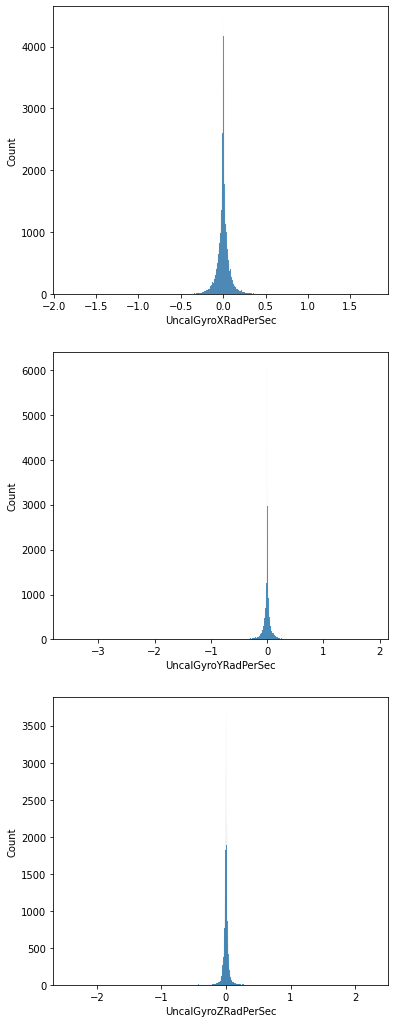

In [70]:
fig, axes = plt.subplots(3, 1, figsize = (6, 18))

sns.histplot(df_train['UncalGyroXRadPerSec'], ax = axes[0])
sns.histplot(df_train['UncalGyroYRadPerSec'], ax = axes[1])
sns.histplot(df_train['UncalGyroZRadPerSec'], ax = axes[2])